# Crowd Layer

In this brief tutorial, we show an example use-case of our package `skactiveml` with the Python package [skorch](https://skorch.readthedocs.io/en/stable/), which is a scikit-learn wrapper for Pytorch models. This way, we are able to implement and test deep learning models in combination with query strategies implemented in our framework.

In [1]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings

from sklearn.metrics import accuracy_score
from torch import nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

mlp.rcParams["figure.facecolor"] = "white"

MISSING_LABEL = -1
RANDOM_STATE = 0
FONTSIZE = 12

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

warnings.filterwarnings("ignore")

## Loading Music Data Set

In [2]:
data_dir = "./music-multi-annotator-dataset"

In [3]:
X_train = np.load(f'{data_dir}/music-X.npy')
y_train = np.load(f'{data_dir}/music-y.npy')
y_train_true = np.load(f'{data_dir}/music-y-true.npy')
X_valid = np.load(f'{data_dir}/music-X-valid.npy')
y_valid = np.load(f'{data_dir}/music-y-true-valid.npy')
X_test = np.load(f'{data_dir}/music-X-test.npy')
y_test_true = np.load(f'{data_dir}/music-y-true-test.npy')

dataset_classes = np.unique(y_test_true)
n_classes = len(dataset_classes)
n_features = X_train.shape[1]
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(X_test.shape)

(700, 124)
(700, 44)
(50, 124)
(250, 124)


## Neural Network Ensemble for tabular data set
In the next step, we define a neural network ensemble for tabular data set

In [4]:
# Define base module.
class ClassifierModule(nn.Module):
    def __init__(self, n_classes, dropout):
        super(ClassifierModule, self).__init__()
        n_hidden_neurons = 128
        self.embed_X_block = nn.Sequential(
            nn.Linear(in_features=124, out_features=n_hidden_neurons),
            nn.BatchNorm1d(num_features=n_hidden_neurons),
            nn.ReLU(),
            nn.Dropout(p=dropout),
        )
        self.mlp = nn.Linear(in_features=n_hidden_neurons, out_features=n_classes)

    def forward(self, x):
        
        embed_x = self.embed_X_block(x)
        logit_class = self.mlp(embed_x)       

        # Compute class-membership probabilities.
        p_class = F.softmax(logit_class, dim=-1)

        return p_class

In [5]:
from skactiveml.base import SkactivemlClassifier, AnnotatorModelMixin
from skorch import NeuralNet
from skactiveml.utils import is_labeled
from skorch.dataset import unpack_data, Dataset
from skorch.helper import predefined_split

In [6]:
class SkorchClassifier(NeuralNet, SkactivemlClassifier):
    def __init__(
        self,
        module,
        *args,
        classes=None,
        missing_label=MISSING_LABEL,
        cost_matrix=None,
        random_state=None,
        **module_kwargs,
    ):
        n_classes = len(classes)
        super(SkorchClassifier, self).__init__(
            module,
            *args,
            module__n_classes=n_classes,
            **module_kwargs,
        )
        
        SkactivemlClassifier.__init__(
            self,
            classes=classes,
            missing_label=missing_label,
            cost_matrix=cost_matrix,
            random_state=random_state,
        )
        
        self.regularized = module_kwargs.get("regularized")
        self.lambda1 = module_kwargs.get("lambda1")

    def get_loss(self, y_pred, y_true, *args, **kwargs):
        loss = super(SkorchClassifier, self).get_loss(y_pred, y_true, *args, **kwargs)
        if self.regularized is not None:
            if self.regularized == 1 and self.lambda1 is float:
                loss += self.lambda1 * sum([w.abs().sum() for w in self.module_.parameters()])
        return loss

    def fit(self, X, y, **fit_params):
        # check input parameters
        self.check_X_dict_ = {
            "ensure_min_samples": 0,
            "ensure_min_features": 0,
            "allow_nd": True,
            "dtype": None,
        }
        X, y, sample_weight = self._validate_data(
            X=X,
            y=y,
            check_X_dict=self.check_X_dict_,
        )

        # check whether model is a valid model

        is_lbld = is_labeled(y, missing_label=self.missing_label)
        try:
            X_lbld = X[is_lbld]
            y_lbld = y[is_lbld].astype(np.int64)
            return super(SkorchClassifier, self).fit(X_lbld, y_lbld, **fit_params)
        except Exception as e:
            self.is_fitted_ = False
            return self

    def initialize(self):
        super(SkorchClassifier, self).check_training_readiness()
        
        super(SkorchClassifier, self)._initialize_virtual_params()
        super(SkorchClassifier, self)._initialize_callbacks()
        super(SkorchClassifier, self)._initialize_module()
        super(SkorchClassifier, self)._initialize_criterion()
        super(SkorchClassifier, self)._initialize_optimizer()
        super(SkorchClassifier, self)._initialize_history()
        
        self.initialized_ = True
        return self

    def predict(self, X):
        return SkactivemlClassifier.predict(self, X)
         

In [7]:
class CrowdLayerClassifier(SkorchClassifier, AnnotatorModelMixin):
    def __init__(self, *args, **kwargs):
        super(CrowdLayerClassifier, self).__init__(
            module=CrowdLayerModule,
            *args, 
            criterion=CrossEntropyLoss(),
            criterion__reduction="mean",
            criterion__ignore_index=MISSING_LABEL,
            **kwargs,
        )

    def get_loss(self, y_pred, y_true, *args, **kwargs):
        # unpack the tuple from the forward function
        p_class, logits_annot = y_pred
        loss = NeuralNet.get_loss(self, logits_annot, y_true, *args, **kwargs)
        return loss
    
    def fit(self, X, y, **fit_params):
        return NeuralNet.fit(self, X, y, **fit_params)
        
    def predict_annotator_perf(self, X, return_confusion_matrix=False):
        n_annotators = self.module__n_annotators
        p_class, logits_annot = self.forward(X)
        p_annot = F.softmax(logits_annot, dim=1)
        P_class = torch.vstack([p for p in p_class]).numpy()
        P_annot = p_annot.numpy()
        P_perf = np.array([np.einsum("ij,ik->ijk", P_class, P_annot[:, :, i]) for i in range(n_annotators)])
        P_perf = P_perf.swapaxes(0, 1)
        if return_confusion_matrix:
            return P_perf
        return P_perf.diagonal(axis1=-2, axis2=-1).sum(axis=-1)
    
    def predict(self, X):
        p_class, logits_annot = self.forward(X)
        return p_class.argmax(axis=1)
    
    def predict_proba(self, X):
        p_class, logits_annot = self.forward(X)
        P_class = torch.vstack([p for p in p_class]).numpy()
        return P_class
    
    def validation_step(self, batch, **fit_params):
        # here put the all things about validation
        # the following one doesn't work very well
        self._set_training(False)
        Xi, yi = unpack_data(batch)
        with torch.no_grad():
            y_pred = self.predict(Xi)
            acc = torch.sum(y_pred == yi) / y_pred.shape[0]
        return {
            'loss': acc,
            'y_pred': y_pred,
        }
    
class CrowdLayerModule(nn.Module):
    def __init__(
        self,
        n_classes,
        n_annotators,
        gt_net,
    ):
        super().__init__()
        self.n_classes = n_classes
        self.n_annotators = n_annotators
        self.gt_net = gt_net

        # Setup crowd layer.
        self.annotator_layers = nn.ModuleList()
        for i in range(n_annotators):
            layer = nn.Linear(n_classes, n_classes, bias=False)
            layer.weight = nn.Parameter(torch.eye(n_classes) * 10)
            self.annotator_layers.append(layer)

    def forward(self, x):
        """Forward propagation of samples through the GT and AP (optional) model.

        Parameters
        ----------
        x : torch.Tensor of shape (batch_size, *)
            Samples.

        Returns
        -------
        p_class : torch.Tensor of shape (batch_size, n_classes)
            Class-membership probabilities.
        logits_annot : torch.Tensor of shape (batch_size, n_annotators, n_classes)
            Annotation logits for each sample-annotator pair.
        """
        # Compute class-membership logits.
        logit_class = self.gt_net(x)

        # Compute class-membership probabilities.
        p_class = F.softmax(logit_class, dim=-1)

        # Compute logits per annotator.
        logits_annot = []
        for layer in self.annotator_layers:
            logits_annot.append(layer(p_class))
        logits_annot = torch.stack(logits_annot, dim=2)

        return p_class, logits_annot

In [8]:
gt_net = ClassifierModule(n_classes=n_classes, dropout=0.0)

In [9]:
valid_ds = Dataset(X_valid, y_valid)

In [11]:
net = CrowdLayerClassifier(
        module__n_annotators=y_train.shape[1],
        module__gt_net=gt_net,
        classes=dataset_classes,
        missing_label=MISSING_LABEL,
        cost_matrix=None,
        random_state=1,
        train_split=predefined_split(valid_ds),
        max_epochs=200,
        batch_size=64,
        optimizer_lr=0.01,
        verbose=False,
        optimizer=torch.optim.AdamW,
        device=device,
        optimizer__weight_decay=0.0
    )

In [12]:
net.initialize()

<class '__main__.CrowdLayerClassifier'>[initialized](
  module_=CrowdLayerModule(
    (gt_net): ClassifierModule(
      (embed_X_block): Sequential(
        (0): Linear(in_features=124, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.0, inplace=False)
      )
      (mlp): Linear(in_features=128, out_features=10, bias=True)
    )
    (annotator_layers): ModuleList(
      (0-43): 44 x Linear(in_features=10, out_features=10, bias=False)
    )
  ),
)

In [13]:
net.module_.annotator_layers[0].weight

Parameter containing:
tensor([[5., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 5., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 5., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 5., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 5., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 5., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 5., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 5., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 5., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 5.]], requires_grad=True)

## Active Classification
For our ensemble, we evaluate four different query strategies, i.e., random sampling, uncertainty sampling, query-by-committee, and batch BALD, regarding their sample selection. For this purpose, we start with ten labels and make 30 iterations of an active learning cycle with a batch size of 32.

In [14]:
# Define setup.
torch.manual_seed(RANDOM_STATE)
y_train_new = np.column_stack([y_train_true for _ in range(44)])

net.fit(X_train,y_train)

<class '__main__.CrowdLayerClassifier'>[initialized](
  module_=CrowdLayerModule(
    (gt_net): ClassifierModule(
      (embed_X_block): Sequential(
        (0): Linear(in_features=124, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.0, inplace=False)
      )
      (mlp): Linear(in_features=128, out_features=10, bias=True)
    )
    (annotator_layers): ModuleList(
      (0-43): 44 x Linear(in_features=10, out_features=10, bias=False)
    )
  ),
)

In [15]:
net.module_.annotator_layers[1].weight

Parameter containing:
tensor([[12.3170, -1.0804,  0.1448, -3.6794, -3.6670, -2.7198, -0.7235, -3.8499,
         -2.4748, -4.3431],
        [-2.2120, 15.5887, -3.2576, -3.3388, -3.1715, -2.4581,  0.4263, -3.6416,
         -2.5120, -4.8945],
        [ 2.7075, -2.7901, 13.7202, -3.7978, -3.5815, -2.8313,  0.0408, -1.1370,
         -2.9605, -4.5805],
        [-2.7451, -3.5986, -4.1937, 16.0242, -3.8693, -0.3691,  0.2091, -1.2678,
         -3.3380, -2.7103],
        [-2.9973, -3.3699, -4.0920, -1.4738, 15.5574, -3.2985,  0.5401,  0.4427,
         -0.1799, -5.5985],
        [-3.2702, -3.2167, -1.7026, -4.4117, -3.6675, 17.1893,  0.6672, -1.1621,
          0.1501, -6.4578],
        [-2.2974, -2.6906, -3.2071, -3.3499, -3.3121, -2.6661,  4.9751, -3.1236,
         -2.0429,  9.3132],
        [-0.4559, -4.2596, -5.1639,  0.7287, -1.2804, -3.5136, -0.0827, 13.2381,
          0.0417, -3.3339],
        [-2.5389, -2.6291, -1.1047, -3.2217, -0.7223, -2.4776, -0.4428,  0.1805,
         11.1286, -4.7191

In [16]:
y_pred = net.predict(X_test)
print(y_pred[:20])
print(y_test_true[:20])

print(accuracy_score(y_pred, y_test_true))
# should be 0.675 from MaDL

tensor([1, 9, 2, 9, 1, 7, 4, 1, 1, 7, 3, 0, 4, 2, 7, 4, 7, 7, 9, 4])
[1 8 2 6 1 7 8 1 1 7 3 2 4 2 3 4 7 5 7 8]
0.604


In [18]:
y_train_pred = net.predict(X_train)
print(y_train_pred[:20])
print(y_train_true[:20])
accuracy_score(y_train_true, y_train_pred)

tensor([4, 7, 4, 7, 8, 7, 2, 2, 8, 3, 0, 9, 7, 2, 2, 0, 5, 2, 8, 9])
[4 7 4 7 8 3 2 2 8 3 0 6 7 2 2 0 5 2 8 9]


0.7014285714285714

In [19]:
history = net.history
history

[{'batches': [{'train_loss': 2.306734800338745, 'train_batch_size': 64},
   {'train_loss': 2.2878313064575195, 'train_batch_size': 64},
   {'train_loss': 2.258759021759033, 'train_batch_size': 64},
   {'train_loss': 2.264611005783081, 'train_batch_size': 64},
   {'train_loss': 2.210829019546509, 'train_batch_size': 64},
   {'train_loss': 2.2624776363372803, 'train_batch_size': 64},
   {'train_loss': 2.2701921463012695, 'train_batch_size': 64},
   {'train_loss': 2.2460010051727295, 'train_batch_size': 64},
   {'train_loss': 2.233205556869507, 'train_batch_size': 64},
   {'train_loss': 2.2342724800109863, 'train_batch_size': 64},
   {'train_loss': 2.212120771408081, 'train_batch_size': 60},
   {'valid_loss': 0.11999999731779099, 'valid_batch_size': 50}],
  'epoch': 1,
  'train_batch_count': 11,
  'valid_batch_count': 1,
  'dur': 0.05281400680541992,
  'train_loss': 2.2536024870191302,
  'train_loss_best': True,
  'valid_loss': 0.11999999731779099,
  'valid_loss_best': True},
 {'batches':

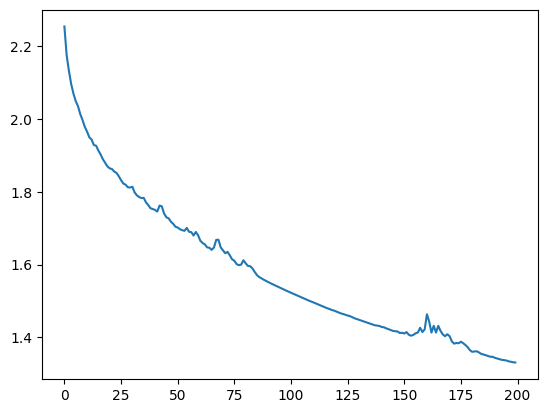

In [20]:
train_loss = history[:, 'train_loss']
plt.plot(train_loss)

In [21]:
proba = net.predict_annotator_perf(X_test)
print(proba)

[[0.19603063 0.16933203 0.10464463 ... 0.08649381 0.11582102 0.11608957]
 [0.13678423 0.12455618 0.09890611 ... 0.08758215 0.10719594 0.10345986]
 [0.15744196 0.16577584 0.10190062 ... 0.08637384 0.10704996 0.09937295]
 ...
 [0.19443336 0.16619958 0.11605267 ... 0.08597384 0.10475305 0.10095424]
 [0.16770118 0.14746381 0.11991154 ... 0.08615482 0.11628865 0.11126642]
 [0.16423991 0.17238787 0.10214803 ... 0.08606824 0.10788848 0.09948275]]
